In [44]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cftime

In [45]:
# This is the official fafstress-antwater forcing file
ds = xr.open_dataset('cmip6_fafmip_fwf01_ant_orca1.nc')

In [46]:
ds

<xarray.Dataset>
Dimensions:          (y: 292, x: 362, time: 12)
Coordinates:
    nav_lat          (y, x) float32 ...
    nav_lon          (y, x) float32 ...
  * time             (time) object 1900-01-16 12:00:00 ... 1900-12-16 12:00:00
Dimensions without coordinates: y, x
Data variables:
    water_flux_anom  (time, y, x) float32 ...
Attributes:
    title:        water flux anomaly around Ant on ORCA1 grid
    institution:  CCCma
    author:       OS: Oleg.Saenko@canada.ca
    history:      Mon Jul  8 18:13:19 2019: ncks --mk_rec_dmn time ras003/cmi...
    NCO:          4.4.2

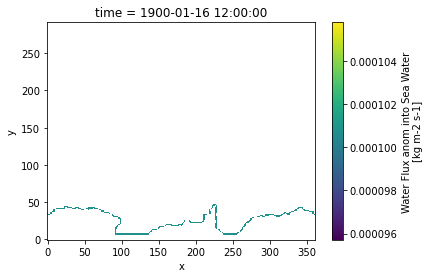

In [47]:
ds.water_flux_anom.isel(time=0).plot()

# Check volume of input

In [48]:
ds_mesh = xr.open_dataset('mesh_mask.nc')

In [49]:
area = ds_mesh.isel(t=0).e1t*ds_mesh.isel(t=0).e2t

In [50]:
kgs_to_sv = 1/(1000*1e6)

In [51]:
((ds.water_flux_anom*area).sum(dim=['x', 'y'])/1e9).plot()

# Define the pattern of forcing only

To be used for scaled forcing

In [52]:
pattern = ds.water_flux_anom.isel(time=0) / ds.water_flux_anom.isel(time=0)

In [53]:
pattern.plot()

# Produce a timeseries of forcing

In [54]:
dates = xr.DataArray(xr.cftime_range(start='1850-01-01', end='1919-12-31', freq='MS', calendar='noleap'), dims='time')

In [55]:
a,b = xr.broadcast(pattern, dates)

In [56]:
scale = np.linspace(0,1, 840)

In [57]:
b = a*scale

In [58]:
b.mean(dim=['x', 'y']).plot()

In [59]:
ds.water_flux_anom.min()

<xarray.DataArray 'water_flux_anom' ()>
array(0.00010075, dtype=float32)

In [60]:
input_area = (pattern*area).sum(dim=['x', 'y'])
input_area

<xarray.DataArray ()>
array(1.03353658e+12)
Coordinates:
    time     object 1900-01-16 12:00:00

In [61]:
(0.0003/1e12)/kgs_to_sv

3e-07

In [62]:
dates = xr.DataArray(xr.cftime_range(start='1850-01-01', end='2100-12-31', freq='MS', calendar='noleap'), dims='time')

In [63]:
dates

<xarray.DataArray (time: 3012)>
array([cftime.DatetimeNoLeap(1850, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 3, 1, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 10, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-01 00:00:00 ... 2100-12-01 00:00:00

In [64]:
# linear ramp at 0.0003 Sv/yr starting in 1970
fwinput = np.cumsum(np.concatenate([np.zeros(1440),np.ones(1572)])*3e-7/12.)

In [65]:
plt.plot(dates, fwinput*1e12*kgs_to_sv)


In [66]:
np.diff(fwinput)*1e12*kgs_to_sv

array([0.0e+00, 0.0e+00, 0.0e+00, ..., 2.5e-05, 2.5e-05, 2.5e-05])

In [67]:
a=fwinput*1e12*kgs_to_sv

In [68]:
a[2040]

0.015025000000000156

In [69]:
dates.isel(time=2040)

<xarray.DataArray ()>
array(cftime.DatetimeNoLeap(2020, 1, 1, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    time     object 2020-01-01 00:00:00

In [70]:
yr2sec=(3600*24*365)

2400e6/yr2sec/917

0.08299182198586151

In [71]:
# How much does sea-level rise (cm/yr) due to input in Gt/yr
ocean_area = (ds_mesh.e1t*ds_mesh.e2t*ds_mesh.tmask.isel(z=0)).sum()

180e12/917/ocean_area*100

<xarray.DataArray ()>
array(0.05371656)

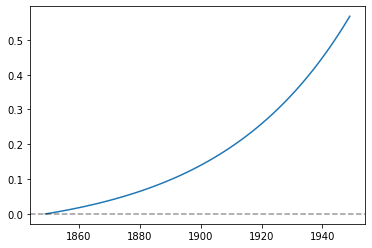

In [72]:
# This would be equivalent to Mackie et al.

t = np.linspace(1849,1949,101)
xo=1770*1e6/yr2sec/917
k=0.0233

eg = (xo)*np.exp(k*(t-1849)) -xo
plt.plot(t,eg)
plt.axhline(0, color='k', alpha=0.4, linestyle='--')
#plt.axhline(17707, color='k', alpha=0.4, linestyle='--')


In [73]:
eg.max()

0.56787003817786

In [74]:
def sv_to_kgs(sv):
    return sv * 1e9
    
def mmyr_to_gtyr(mmyr):
    # Convert from mm/yr of SLR to input of FW in Gt/yr    
    return mmyr/1000*ocean_area*917/1e12

def mmyr_to_sv(mmyr):
    # Convert from mm/yr of SLR to input of FW in SV
    return mmyr/1000*ocean_area/1e6/yr2sec

def gtyr_to_sv(gtyr):
    # convert from gt/yr to Sv
    return gtyr*1e6/yr2sec/917

In [79]:
gtyr_to_sv(12000)

0.4149591099293075

In [40]:
mmyr_to_sv(60)

<xarray.DataArray ()>
array(0.69524782)

In [38]:
# make a timeseries for output to NetCDF
dates = xr.DataArray(xr.cftime_range(start='1849-01-01', end='1949-12-31', freq='A', calendar='noleap'), dims='time')
input_area = (pattern*area).sum(dim=['x', 'y'])

# convert e.g. from Sv to kg/m2/s
scale = sv_to_kgs(eg) / input_area.values

a,b = xr.broadcast(pattern, dates)

fw_input = a*scale

fw_input.to_netcdf('ncs_sofw_1ppy_2.33percent_1849_1949.nc')

In [39]:
gtyr_to_sv(3000)


0.10373977748232688

In [46]:
# Try to construct a semi-realistic scenario

# make a timeseries for output to NetCDF
dates = xr.DataArray(xr.cftime_range(start='1850-01-01', end='2100-12-31', freq='A', calendar='noleap'), dims='time')
input_area = (pattern*area).sum(dim=['x', 'y'])


t = np.linspace(1969,2100,132)
xo=0.001
k=0.04

colors = plt.cm.jet(np.linspace(0,1,5))

for i, k in enumerate([0.03,0.04,0.05]):
    eg = xo*np.exp(k*(t-1969)) - xo
    plt.plot(t,eg, color=colors[i]) 
    print(eg[0:2])
    # convert e.g. from Sv to kg/m2/s
    scale = np.concatenate([np.zeros(1969-1850), sv_to_kgs(eg) / input_area.values])
    a,b = xr.broadcast(pattern, dates)
    fw_input = a*scale
    per=str(int(k*100))
    fw_input.to_netcdf(f'ncs_sofw_hist-spp_{per}percent_1850_2100.nc', mode='w')

# The AR6 gives 0.53 mm/yr as SLR from AIS over 2006 to 2018 (Table 9.5).
# This is about 180 Gt/yr - 0.53/1000*ocean_area*917/1e12
#plt.axhline(xo, color='k', alpha=0.4, linestyle='--')
plt.axhline(180*1e6/yr2sec/917, color='k', alpha=0.4, linestyle='--')
plt.axvline(2006, color='k', alpha=0.4, linestyle='--')
plt.axvline(2018, color='k', alpha=0.4, linestyle='--')
plt.errorbar(2012, mmyr_to_sv(0.53), yerr=mmyr_to_sv(0.13))
plt.xlabel('Year')
plt.ylabel('AIS FW input (Sv)')
plt.ylim([0,0.1])
#plt.yscale('log')
#plt.xlim([1965,1975])


[0.0000000e+00 3.0454534e-05]
[0.00000000e+00 4.08107742e-05]
[0.00000000e+00 5.12710964e-05]


(0, 0.1)

In [47]:
ds2 = xr.open_dataset('ncs_sofw_hist-spp_3percent_1849_2100.nc')
ds2.water_flux_anom.mean(dim=['x', 'y']).plot()
ds2.time

<xarray.DataArray 'time' (time: 252)>
array([cftime.DatetimeNoLeap(1849, 12, 31, 0, 0, 0, 0, 1, 365),
       cftime.DatetimeNoLeap(1850, 12, 31, 0, 0, 0, 0, 2, 365),
       cftime.DatetimeNoLeap(1851, 12, 31, 0, 0, 0, 0, 3, 365), ...,
       cftime.DatetimeNoLeap(2098, 12, 31, 0, 0, 0, 0, 5, 365),
       cftime.DatetimeNoLeap(2099, 12, 31, 0, 0, 0, 0, 6, 365),
       cftime.DatetimeNoLeap(2100, 12, 31, 0, 0, 0, 0, 0, 365)], dtype=object)
Coordinates:
  * time     (time) object 1849-12-31 00:00:00 ... 2100-12-31 00:00:00

In [1]:
!ls

antwater-analysis.ipynb		 ds_omon_03_rm.nc
antwater_processing.ipynb	 ds_omon_04_rm.nc
antwater_processing.py		 ds_omon_05_rm.nc
bu				 ds_omon_06_rm.nc
canesm5-antwater-cat.json	 ds_omon_07_rm.nc
canesm5_antwater.csv.gz		 ds_omon_1ppy_rm.nc
cmip6_fafmip_fwf01_ant_orca1.nc  ds_omon_fa02_rm.nc
dask-worker-space		 ds_omon_fa03_rm.nc
ds_amon_01_rm.nc		 ds_omon_fafstress_rm.nc
ds_amon_02_rm.nc		 ds_omon_fas_rm.nc
ds_amon_03_rm.nc		 ds_omon_pi-full_rm.nc
ds_amon_04_rm.nc		 ds_omon_pi_rm.nc
ds_amon_05_rm.nc		 fafmip_antwater.ipynb
ds_amon_06_rm.nc		 intake-esm-datastore
ds_amon_07_rm.nc		 mesh_mask.nc
ds_amon_1ppy_rm.nc		 ncs_sofw_1ppy_2.33percent_1849_1949.nc
ds_amon_fa02_rm.nc		 ncs_sofw_hist-spp_3percent_1850_2100.nc
ds_amon_fa03_rm.nc		 ncs_sofw_hist-spp_4percent_1850_2100.nc
ds_amon_fafstress_rm.nc		 ncs_sofw_hist-spp_5percent_1850_2100.nc
ds_amon_fas_rm.nc		 neil_fafmip_fw-linear-to-0dot1sv_ant_orca1.nc
ds_amon_pi_rm.nc		 remapped
ds_omon_01_rm.nc		 sst_sss_04-pi.png
ds_omon_02_rm.nc		

In [49]:
!pwd

/fs/site4/eccc/crd/ccrn/users/ncs001/canesm5-analysis/antwater


In [51]:
!which python

/home/ncs001/.conda/envs/py3_analysis_v1_ncs/bin/python


In [4]:
ds = xr.open_dataset('neil_fafmip_fw-linear-to-0dot1sv_ant_orca1.nc')

In [ ]:
ds.isel(time=2).water_flux_anom.plot()